<a href="https://colab.research.google.com/github/VladimirVladetic/AgePrediction/blob/main/AgeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from google.colab import files

In [2]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [3]:
! kaggle datasets download -d jangedoo/utkface-new

with zipfile.ZipFile('/content/utkface-new.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

folder_to_delete = '/content/sample_data'
shutil.rmtree(folder_to_delete)
folder_to_delete = '/content/crop_part1'
shutil.rmtree(folder_to_delete)
folder_to_delete = '/content/utkface_aligned_cropped'
shutil.rmtree(folder_to_delete)

100% 331M/331M [00:14<00:00, 22.4MB/s]
100% 331M/331M [00:14<00:00, 23.5MB/s]


In [4]:
! kaggle datasets download -d frabbisw/facial-age

100% 837M/840M [00:37<00:00, 23.0MB/s]
100% 840M/840M [00:37<00:00, 23.3MB/s]


In [5]:
with zipfile.ZipFile('/content/facial-age.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [2]:
def get_image_paths_age_gender_labels(image_directory):
    image_paths = []
    age_labels = []
    gender_labels = []
    for filename in tqdm(os.listdir(image_directory )):
        image_path = os.path.join(image_directory,filename)
        temporary_data = filename.split("_")
        age = int(temporary_data[0])
        gender = int(temporary_data[1])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    return image_paths, age_labels, gender_labels

In [3]:
def append_images_from_folders(existing_paths, existing_age_labels, new_dataset_path):
    new_image_paths = []
    new_age_labels = []

    for age_folder in tqdm(os.listdir(new_dataset_path)):
        age_label = int(age_folder)
        age_image_folder = os.path.join(new_dataset_path, age_folder)

        for filename in os.listdir(age_image_folder):
            image_path = os.path.join(age_image_folder, filename)
            new_image_paths.append(image_path)
            new_age_labels.append(age_label)

    combined_paths = existing_paths + new_image_paths
    combined_age_labels = existing_age_labels + new_age_labels

    return combined_paths, combined_age_labels

In [4]:
def map_age_to_category(age):
  age_ranges = [(0, 2), (3, 9), (10, 20), (21, 29), (30, 45), (46, 60), (61, 80), (81, 120)]
  for category, (min_age, max_age) in enumerate(age_ranges, start=0):
          if min_age <= age <= max_age:
              return category
  return 0

In [5]:
# Plotting age histogram
def plot_age(df):
    plt.figure(figsize=(15, 5))
    df['age'].plot(kind='hist', bins=20, edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

In [6]:
def extract_features(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = load_img(image, color_mode='grayscale')
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        ## Normalization of images
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 1)
    ## from float64 to float32
    features = np.array(features, dtype=np.float32)
    return features

In [7]:
def create_model(input_shape,num_age_classes):
    inputs = Input(input_shape)

    conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    batch_1 = BatchNormalization()(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(batch_1)
    batch_2 = BatchNormalization()(conv_2)

    maxpool_1 = MaxPooling2D(pool_size=(2,2))(batch_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(dropout_1)
    batch_3 = BatchNormalization()(conv_3)
    conv_4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(batch_3)
    batch_4 = BatchNormalization()(conv_4)

    maxpool_2 = MaxPooling2D(pool_size=(2,2))(batch_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(dropout_2)
    batch_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(batch_5)
    batch_6 = BatchNormalization()(conv_6)

    # conv_7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(batch_6)
    # batch_7 = BatchNormalization()(conv_7)

    # maxpool_3 = MaxPooling2D(pool_size=(2,2))(batch_7)
    # dropout_3 = Dropout(0.25)(maxpool_3)

    # conv_8 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(dropout_3)
    # batch_8 = BatchNormalization()(conv_8)
    # conv_9 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(batch_8)
    # batch_9 = BatchNormalization()(conv_9)

    flatten = Flatten()(batch_6)

    dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)

    dropout_1 = Dropout(0.3)(dense_1)

    dense_2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)

    output = Dense(num_age_classes, activation='softmax', name="age_out")(dense_2)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [8]:
image_directory = "/content/UTKFace/"

image_paths, age_labels, gender_labels = get_image_paths_age_gender_labels(image_directory)

new_dataset_path = '/content/face_age/face_age/'

image_paths, age_labels = append_images_from_folders(image_paths, age_labels, new_dataset_path)

age_categories = [map_age_to_category(age) for age in age_labels]

gender_dictionary = {0:"Male",1:"Female"}

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [9]:
combined_df = pd.DataFrame()
combined_df = pd.DataFrame({'image': image_paths, 'age': age_categories})

image_height = 128
image_width = 128
num_age_classes = 8

In [10]:
print(combined_df)

                                                   image  age
0      /content/UTKFace/22_1_4_20170103224503415.jpg....    3
1      /content/UTKFace/3_0_3_20161220145012367.jpg.c...    1
2      /content/UTKFace/23_1_0_20170103180451856.jpg....    3
3      /content/UTKFace/26_0_3_20170119183851623.jpg....    3
4      /content/UTKFace/47_0_0_20170104211911013.jpg....    5
...                                                  ...  ...
33481            /content/face_age/face_age/049/2272.png    5
33482             /content/face_age/face_age/087/507.png    7
33483            /content/face_age/face_age/087/5627.png    7
33484             /content/face_age/face_age/087/284.png    7
33485            /content/face_age/face_age/087/6531.png    7

[33486 rows x 2 columns]


In [11]:
# combined_df_train_subset = combined_df.head(32000)
# combined_df_test_subset = combined_df.tail(1486)

In [11]:
X = extract_features(combined_df["image"],image_height,image_width)

y_age = np.array(combined_df["age"])

y_age = np.array(list(combined_df["age"].apply(lambda x: to_categorical(x, num_classes=num_age_classes))))

# y_gender_tensor = tf.convert_to_tensor(y_gender, dtype=tf.float32)
y_age_tensor = tf.convert_to_tensor(y_age, dtype=tf.float32)

input_shape = (image_height,image_width,1)

  0%|          | 0/33486 [00:00<?, ?it/s]

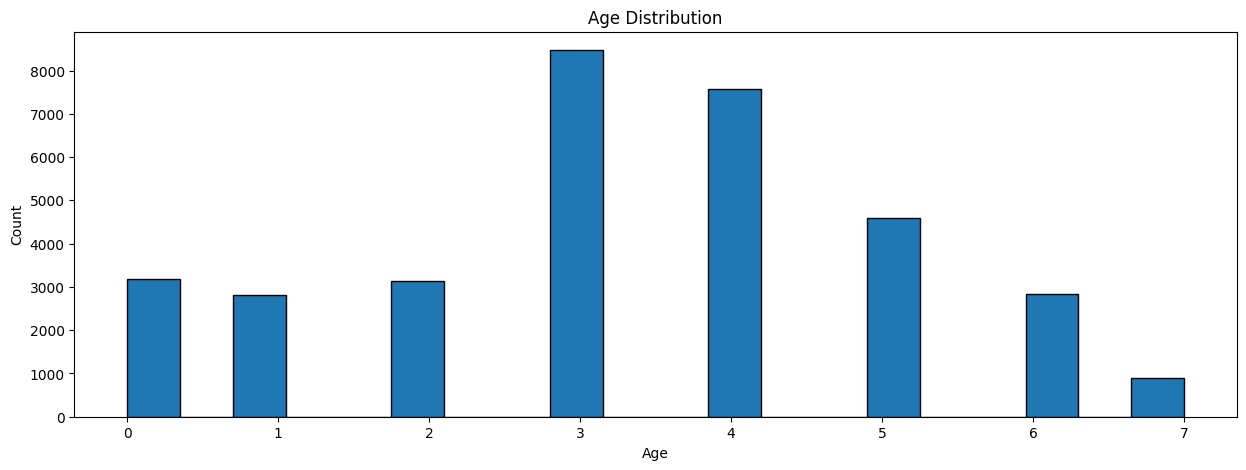

In [12]:
plot_age(combined_df)

In [13]:
print(len(y_age))
print(len(X))

33486
33486


In [14]:
opt = Adam(learning_rate=0.01)

model = create_model(input_shape, num_age_classes)

model.compile(loss="categorical_crossentropy", optimizer = opt, metrics='accuracy' )

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(x=X, y=y_age_tensor, batch_size=64, epochs=50, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
  1/419 [..............................] - ETA: 2:35:22 - loss: 12.0307 - accuracy: 0.1250

KeyboardInterrupt: 